# Variational Autoencoder: PyTorch and CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.10.0+cu111


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: Tesla K80


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Hyper-parameters-
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### CIFAR-10 data pre-processing:

In [6]:
"""
# Dataset has PILImage images of range [0, 1]. We transform them to Tensors
# of normalized range [-1, 1]
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
"""

# Define transformations for CIFAR-10 training & test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [ ]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"

In [7]:
# Load CIFAR-10 dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        # root = path_to_data + "data", train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        # root = path_to_data + "data", train = True,
        download = True, transform = transform_test
        )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [9]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 50000 and test_dataet: 10000
Sizes of train_loader: 782 and test_loader: 157


In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [11]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [15]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 3, 32, 32]) & labels.shape: torch.Size([64])


In [13]:
# Unnormalize images-
images = images / 2 + 0.5
images = np.transpose(images.numpy(), (0, 2, 3, 1))

In [14]:
images.shape

(64, 32, 32, 3)

In [ ]:
images[0].shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


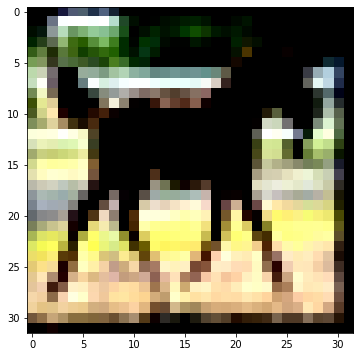

In [ ]:
plt.figure(figsize = (7, 6))
plt.imshow(images[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

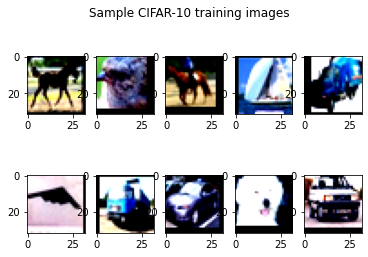

In [ ]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i])
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

### Define _Variational Autoencoder_ architecture:

In [16]:
class cnn_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(cnn_block, self).__init__()

        # Define layers-
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = output_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2
        )
  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.pool(x)
    

In [17]:
class Conv6_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv6_Encoder, self).__init__()
        self.latent_space = latent_space
        
        self.block1 = cnn_block(input_channels = 3, output_channels = 64)
        self.block2 = cnn_block(input_channels = 64, output_channels = 128)
        self.block3 = cnn_block(input_channels = 128, output_channels = 256)
        self.dense_layer1 = nn.Linear(
            in_features = 4096, out_features = 256,
            bias = True
        )
        self.op_layer = nn.Linear(
            in_features = 256, out_features = self.latent_space,
            bias = True
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.dense_layer1(x)
        x = self.op_layer(x)
        return x

In [18]:
class Conv6_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv6_Decoder, self).__init__()
        self.latent_space = latent_space
    
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 256,
            bias = True
        )
        self.dense_layer2 = nn.Linear(
            in_features = 256, out_features = 4096,
            bias = True
        )
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 128,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer4 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran_layer5 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 64,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer6 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.output_conv_layer = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 3,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        
    
    def forward(self, x):
        x = F.relu(self.dense_layer1(x))
        x = F.relu(self.dense_layer2(x))
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.conv_tran_layer1(x))
        x = F.relu(self.conv_tran_layer2(x))
        x = F.relu(self.conv_tran_layer3(x))
        x = F.relu(self.conv_tran_layer4(x))
        x = F.relu(self.conv_tran_layer5(x))
        x = F.relu(self.conv_tran_layer6(x))
        x = self.output_conv_layer(x)
        return x
 

In [ ]:
# Instantiate an instance of encoder-
# encoder = Conv6_Encoder(latent_space = 20).to(device)

In [ ]:
# images.shape

torch.Size([64, 3, 32, 32])

In [ ]:
# encoded_images = encoder(images)

In [ ]:
# encoded_images.shape

torch.Size([64, 20])

In [ ]:
# Instantiate an instance of decoder-
# decoder = Conv6_Decoder(latent_space = 20).to(device)

In [ ]:
# decoded_output = decoder(encoded_images)

In [ ]:
# decoded_output.shape

torch.Size([64, 3, 32, 32])

In [ ]:
# del encoder, decoder, encoded_images, decoded_output

In [19]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = Conv6_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        self.hidden2log_var = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        
        # Decoder-
        self.decoder = Conv6_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))  # or, tanh
        # x = self.decoder(z)
        # recon_data = torch.sigmoid(x) # or, tanh
        
        return recon_data, mu, log_var
        

In [20]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 20).to(device)

In [21]:
print(model)

VAE_Conv(
  (encoder): Conv6_Encoder(
    (block1): cnn_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): cnn_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): cnn_block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dense_layer1): Linear(in_features=4096, out_features=256, bias=True)
    (op_layer): Linear(in_features=2

In [22]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256, 4096]) has 1048576 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([20, 256]) has 5120 parameters
layer.shape = torch.Size([20]) has 20 parameters
layer.shape = torch.Size([20, 20]) has 400 parameters
layer.shape = torch.Size([20]) has 20 parameter

In [23]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 5738975


### Initial _variance_ - Sanity check:

_Before_ training the VAE neural network model, there should be some initial variance.

In [ ]:
for x in model.hidden2mu.parameters():
    print(x.shape, x.nelement())

torch.Size([20, 20]) 400
torch.Size([20]) 20


In [ ]:
log_var_wts = model.hidden2log_var.weight

In [ ]:
mu_wts = model.hidden2mu.weight

In [ ]:
mu_wts = mu_wts.detach().cpu().numpy()

In [ ]:
log_var_wts = log_var_wts.detach().cpu().numpy()

In [ ]:
mu_wts.shape, log_var_wts.shape

((20, 20), (20, 20))

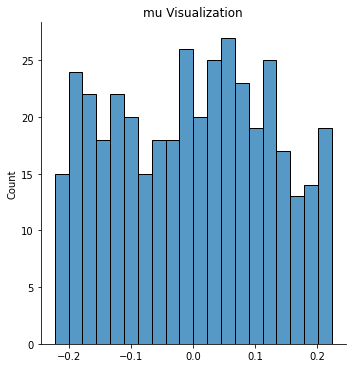

In [ ]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu Visualization")
plt.show()

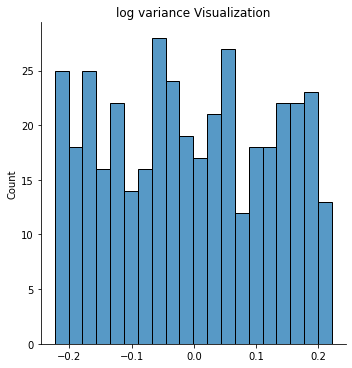

In [ ]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance Visualization")
plt.show()

In [ ]:
del mu_wts, log_var_wts

In [ ]:
images = images.to(device)

In [ ]:
images.shape

torch.Size([64, 3, 32, 32])

In [ ]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [ ]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 20]), torch.Size([64, 20]))

In [ ]:
del recon_images, mu, log_var

In [24]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [25]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [26]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch documentations, then this is
# specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')

In [27]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [28]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        recon_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(recon_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    
    return train_loss, mu, logvar


In [29]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total = int(len(test_dataset) / dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            recon_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(recon_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()

            '''
            # save the last batch input and output of every epoch
            if i == int(len(test_dataset) / dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
            '''
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss, mu, logvar


In [ ]:
# alpha = 1

In [ ]:
# Sanity check-
'''
train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = alpha
    )
'''

In [ ]:
# Sanity check-
'''
test_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = alpha
    )
'''

157it [00:09, 16.04it/s]                         


In [ ]:
# print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

train loss = 21299.9876 & test loss = 21293.4824


In [30]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [31]:
# Python dict to contain training metrics-
train_history = {}

In [32]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [33]:
for epoch in range(1, num_epochs + 1):
    train_epoch_loss, mu_train, logvar_train = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )

    val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )

    logvar_train = logvar_train.mean().detach().cpu().numpy()
    logvar_val = logvar_val.mean().detach().cpu().numpy()
    mu_train = mu_train.mean().detach().cpu().numpy()
    mu_val = mu_val.mean().detach().cpu().numpy()

    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        'val_loss': val_epoch_loss,
        'train_logvar': logvar_train,
        'val_logvar': logvar_val,
        'train_mu': mu_train,
        'val_mu': mu_val
    }

    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
    f"test loss = {val_epoch_loss:.4f}, train_logvar = {logvar_train:.6f}"
    f", train_mu = {mu_train:.6f}, val_logvar = {logvar_val:.6f} &"
    f" val_mu = {mu_val:.6f}")
    

782it [02:22,  5.49it/s]
157it [00:12, 12.86it/s]                         


Epoch = 1; train loss = 6379.1685,test loss = 4776.8861, train_logvar = 0.001016, train_mu = 0.000182, val_logvar = 0.001007 & val_mu = 0.000172


782it [02:21,  5.53it/s]
157it [00:12, 12.78it/s]                         


Epoch = 2; train loss = 6369.2239,test loss = 4776.8856, train_logvar = 0.000027, train_mu = 0.000003, val_logvar = 0.000029 & val_mu = -0.000000


782it [02:21,  5.54it/s]
157it [00:12, 12.89it/s]                         


Epoch = 3; train loss = 6368.6680,test loss = 4776.8856, train_logvar = -0.000001, train_mu = 0.000012, val_logvar = -0.000004 & val_mu = 0.000039


782it [02:23,  5.45it/s]
157it [00:12, 12.78it/s]                         


Epoch = 4; train loss = 6369.8587,test loss = 4776.8856, train_logvar = 0.000005, train_mu = -0.000010, val_logvar = 0.000018 & val_mu = -0.000044


782it [02:22,  5.48it/s]
157it [00:12, 12.85it/s]                         


Epoch = 5; train loss = 6365.1827,test loss = 4776.8856, train_logvar = -0.000005, train_mu = 0.000023, val_logvar = -0.000006 & val_mu = 0.000043


782it [02:21,  5.53it/s]
157it [00:12, 12.81it/s]                         


Epoch = 6; train loss = 6370.2585,test loss = 4776.8856, train_logvar = 0.000007, train_mu = -0.000003, val_logvar = 0.000002 & val_mu = 0.000012


782it [02:21,  5.53it/s]
157it [00:12, 12.85it/s]                         


Epoch = 7; train loss = 6370.9306,test loss = 4776.8856, train_logvar = 0.000003, train_mu = -0.000062, val_logvar = 0.000008 & val_mu = -0.000119


782it [02:23,  5.45it/s]
157it [00:12, 12.88it/s]                         


Epoch = 8; train loss = 6368.0712,test loss = 4776.8856, train_logvar = 0.000026, train_mu = -0.000058, val_logvar = 0.000040 & val_mu = -0.000091


782it [02:22,  5.49it/s]
157it [00:12, 12.79it/s]                         


Epoch = 9; train loss = 6364.9516,test loss = 4776.8856, train_logvar = 0.000002, train_mu = -0.000015, val_logvar = 0.000013 & val_mu = -0.000037


782it [02:21,  5.53it/s]
157it [00:12, 12.82it/s]                         


Epoch = 10; train loss = 6363.6801,test loss = 4776.8856, train_logvar = 0.000013, train_mu = -0.000024, val_logvar = 0.000020 & val_mu = -0.000033


 52%|█████▏    | 407/781 [01:13<01:07,  5.52it/s]


KeyboardInterrupt: ignored

In [ ]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_Conv_CIFAR10_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_Conv_CIFAR10_Trained_Weights', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [ ]:
import pickle

# Save training history as pickle file-
with open("VAE_Conv_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_Conv_CIFAR10_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

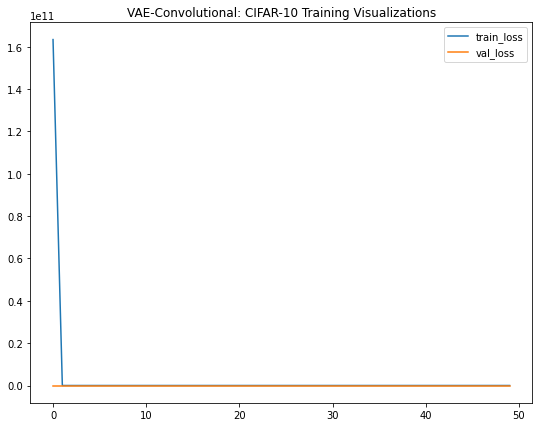

In [ ]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.plot([train_history[x]['val_loss'] for x in train_history.keys()], label = 'val_loss')
plt.legend(loc = 'best')
plt.title("VAE-Convolutional: CIFAR-10 Training Visualizations")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model:

In [ ]:
images = images.to(device)

In [ ]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [ ]:
# For CPU-
recon_images = recon_images.detach().numpy()
mu = mu.detach().numpy()
log_var = log_var.detach().numpy()

In [ ]:
recon_images.shape, mu.shape, log_var.shape

In [ ]:
# Unnormalize images-
recon_images = recon_images / 2 + 0.5
recon_images = np.transpose(recon_images, (0, 2, 3, 1))

In [ ]:
recon_images.shape

(64, 32, 32, 3)

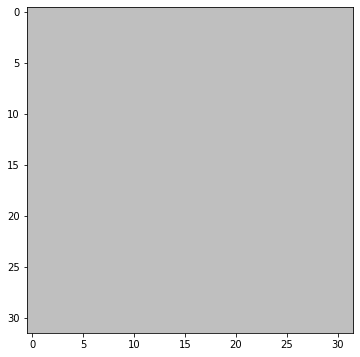

In [ ]:
plt.figure(figsize = (7, 6))
plt.imshow(recon_images[0])
plt.show()


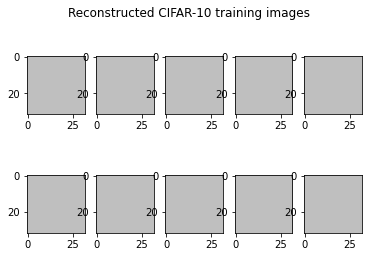

In [ ]:
# Visualize 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(recon_images[i])
    
plt.suptitle("Reconstructed CIFAR-10 training images")
plt.show()


In [ ]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [ ]:
recon_images.shape

(64, 3, 32, 32)

In [ ]:
mu[mu > 0.0002].shape

(638,)

In [ ]:
log_var[log_var <= -0.001].shape

(57,)

In [ ]:
mu.shape

(64, 20)

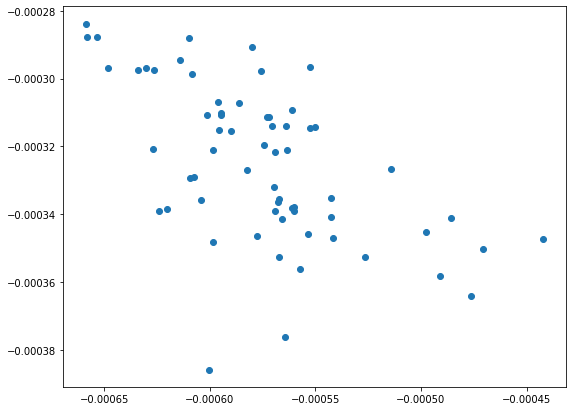

In [ ]:
plt.figure(figsize = (9, 7))
plt.scatter(x = mu[:, 2], y = mu[:, 3])
plt.show()

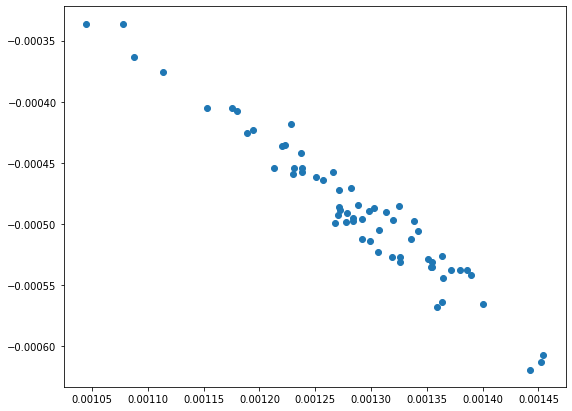

In [ ]:
plt.figure(figsize = (9, 7))
plt.scatter(x = log_var[:, 2], y = log_var[:, 3])
plt.show()

In [ ]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0].cpu(), cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [ ]:
# Print 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample CIFAR-10 reconstructed images")
plt.show()

In [ ]:
# Print 50 images from reconstructions-
plt.figure(figsize = (9, 7))

for i in range(50):
    plt.subplot(10, 5, i + 1)    # 10 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample CIFAR-10 reconstructed images")
plt.show()

In [ ]:
'''
# Iterating over train loader-
for img, label in train_loader:
    print(img.shape, label.shape)
'''

In [ ]:
# Get a batch of training data & it's corresponding labels-
images, labels = next(iter(train_loader))
images = images.to(device)

In [ ]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [ ]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [ ]:
recon_images.shape, mu.shape, log_var.shape

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [ ]:
embedding_mu = reducer.fit_transform(mu)
embedding_mu.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(64, 3)

In [ ]:
reducer_logvar = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [ ]:
embedding_logvar = reducer.fit_transform(log_var)
embedding_logvar.shape

(64, 3)

In [ ]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = embedding_mu[:, 0], y = embedding_mu[:, 1],
    z = embedding_mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = embedding_logvar[:, 0], y = embedding_logvar[:, 1],
    z = embedding_logvar[:, 2],
    # color = y_train
    )
fig.show()